<div style="text-align:center"><span style="color:blue; font-family:Times New Roman; font-size:3em;"> Data modeling  </span></div>

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import warnings
warnings.filterwarnings("ignore")
from sklearn.externals import joblib

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import ModelCheckpoint
from keras import backend as K
K.set_image_dim_ordering('th')
import h5py
from keras.layers.normalization import BatchNormalization
from sklearn.preprocessing import MinMaxScaler

Using Theano backend.


<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;">I load the train data (X) and the test data (X_test) which are already preprocessed in the previous stage. 
 </span></div>

In [9]:
X=pd.read_csv('X.csv', index_col=0)
X_test=pd.read_csv('X_test.csv', index_col=0)
X=X.take(np.random.permutation(len(X)))
Y=X['reordered']
X.drop(['reordered','user_id', 'product_id'], axis=1, inplace=True)
X_test.drop(['user_id', 'product_id'], axis=1, inplace=True)
X.columns

Index([u'total_orders_user', u'unique_items_user', u'total_items_user',
       u'average_items_per_order', u'average_days_per_order', u'appear_rate',
       u'reorder_num', u'add_to_cart_order', u'total_order_minus_last_order',
       u'last_order_ratio', u'aisle_id', u'department_id', u'user_num_product',
       u'product_total_orders', u'product_total_reorders', u'reorder_ratio',
       u'last_1st_order', u'last_2st_order', u'last_3st_order',
       u'last_4st_order', u'last_5st_order', u'last_6st_order',
       u'last_7st_order', u'last_8st_order', u'last_9st_order',
       u'last_10st_order', u'last_11st_order', u'last_12st_order',
       u'last_13st_order', u'last_14st_order', u'last_15st_order',
       u'last_16st_order', u'last_17st_order', u'last_18st_order',
       u'last_19st_order', u'last_20st_order', u'last_five_orders_sum',
       u'last_10_orders_sum', u'last_15_orders_sum', u'last_20_orders_sum'],
      dtype='object')

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;">The train data is shuffled and divided into the train set (80%) and the validation set (20%) by preserving the same percentage for each target class as in the complete set. In order to train neural network, the data is normalized to be in the range between 0 and 1. 
 </span></div>

In [10]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)
i=1
for train_index, valid_index  in skf.split(X, Y):
    joblib.dump(X.values[train_index],'X_train_modify_{}.pkl'.format(i))
    joblib.dump(Y.values[train_index],'Y_train_modify_{}.pkl'.format(i))
    joblib.dump(X.values[valid_index],'X_valid_modify_{}.pkl'.format(i))
    joblib.dump(Y.values[valid_index],'Y_valid_modify_{}.pkl'.format(i))
    i += 1

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;">
The neural network structure consists of one input layer, six hidden layers and one output layer. The weights are initialized using small Gaussian random numbers. The Rectifier activation function is used for each hidden layer. Two Dropout layers are applied to prevent overfitting. I also add Batch Normalization to each hidden layer of the network to perform the normalization for each training mini-batch. Batch Normalization allows us to use much higher learning rates and increase model performance. 
The output layer has a single neuron and a sigmoid activation is used for purposes of probabilistic classification. Finally the logarithmic loss function (binary_crossentropy) during training is used for binary classification. The model uses the efficient Adamax optimization algorithm for gradient descent and accuracy metrics is evaluated when the model is trained. 
I use the class_weights in the model.fit method to handle the imbalanced train data.
The class weights are calculated by inversely proportional to class frequencies in the input data.
I train the network for 500 epochs, with 1000 samples per mini-batch. The model weights that give the best result (lowest loss in the validation set) are saved for model evaluation and prediction of the test data. 

 </span></div>

In [10]:
def NNmodel(X_scaled_train, y_train,X_scaled_valid, y_valid,optimizer,batch_size,nb_epoch, c1, c2, c3, c4,c5,c6,drop1, \
            drop2, init,testnumber):
    model=Sequential()
    model.add(Dense(c1, input_dim=X_train.shape[1], init = init, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(drop1))
    model.add(Dense(c2, init = init, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(drop2))
    model.add(Dense(c3, init = init, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(c4, init = init, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(c5, init = init, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(c6, init = init, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, init = init, activation='sigmoid'))
  
    from sklearn.utils import class_weight
    class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer,metrics=['accuracy']) 
    filepath="model_{}.best.hdf5".format(testnumber)
    saveBestModel = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
    model.fit(X_scaled_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch, class_weight=class_weight,
              validation_data=(X_scaled_valid, y_valid),callbacks=[saveBestModel],verbose=0) 
    return

In [ ]:
def NNmodel_prediction(X_scaled_test,optimizer,batch_size,c1, c2, c3, c4,c5,c6,drop1, drop2, init,testnumber):
    model=Sequential()
    model.add(Dense(c1, input_dim=X_train.shape[1], init = init, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(drop1))
    model.add(Dense(c2, init = init, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(drop2))
    model.add(Dense(c3, init = init, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(c4, init = init, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(c5, init = init, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(c6, init = init, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, init = init, activation='sigmoid'))
  
    filepath="model_{}.best.hdf5".format(testnumber)
    model.load_weights(filepath)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer,metrics=['accuracy']) 
    y_pred_test = model.predict_proba(X_scaled_test, batch_size=batch_size, verbose=0)
    return y_pred_test

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;">
Five-fold train/validation combinations are iterated and trained in the neural network model. The test data is fed into the model which generates 5 predictions via the iterations. The final prediction for the test data is obtained by averaging all 5 predictions in order to reduce overfitting.

 </span></div>

In [ ]:
y_pred_all=[]
for i in range(1,6):
    ## load data 
    X_train=joblib.load('X_train_modify_{}.pkl'.format(i))
    Y_train=joblib.load('Y_train_modify_{}.pkl'.format(i))
    X_valid=joblib.load('X_train_modify_{}.pkl'.format(i))
    Y_valid=joblib.load('Y_train_modify_{}.pkl'.format(i))
    ## scale data
    scaler=MinMaxScaler()
    X_scaled_train=scaler.fit_transform(X_train)
    X_scaled_valid=scaler.transform(X_valid)
    X_scaled_test=scaler.transform(X_test.values)
    ## train data
    NNmodel(X_scaled_train, Y_train,X_scaled_valid, Y_valid,'adamax',1000,500, \
            500, 400, 400,200, 150,150,0.4, 0.4, 'normal',i)
    ## predict data
    y_pred_test=NNmodel_prediction(X_scaled_test,'adamax', 1000,500, 400, 400,200, 150,150,0.4, 0.4, 'normal',i)
    y_pred_all.append(y_pred_test)

In [ ]:
y_pred_all=np.array(y_pred_all)
y_pred_average=np.average(y_pred_all, axis=0)

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;">
In the Kaggle competition of Instacart Market Basket Analysis, the evaluation of the prediction results is based on the F1 score. The F1 score is a weighted average of precision and recall. The F1 score needs be maximized to ensure that both precision and recall are high. In order to maximize the F1 score, an appropriate probability threshold is set to predict the output labels of the test data. In the end, the prediction of the reordered products in the latest purchase of the test users is summited to Kaggle. The F1 score shown in the Leaderboard of Kaggle is 0.373. 
 </span></div>

In [ ]:
thresh=0.24
y_pred_binary=np.where(y_pred_average[:, 0]>thresh, 1,0)
X_test_new=X_test.copy()
X_test_new['pred']=y_pred_binary
X_test_new['prediction_pro']=y_pred_test[:, 0]
X_test_new['product_id']=X_test_new['product_id'].astype(int)
prediction=X_test_new[X_test_new.pred==1].groupby('user_id')['product_id'].\
apply(lambda x: ' '.join([str(e) for e in set(x)]))

In [ ]:
test = pd.read_csv("sample_submission.csv")
prior_train=pd.read_csv('prior_train_final.csv')
submission=pd.merge(test, prior_train,on='order_id', how='left')[['order_id', 'user_id']]
submission['products']=submission.user_id.map(prediction)
submission['products'].fillna('None', inplace=True)
submission[['order_id','products']].to_csv('submission.csv', index=False)

<div style="text-align:center"><span style="color:blue; font-family:Times New Roman; font-size:3em;"> Conclusion  </span></div>

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
In this project, I have developed a neural network model to predict which products users will buy again in their next purchase. The NN model combined with feature engineering technique can well capture both sequential behavior and general taste of users, leading to 0.373 of the F1 score in the Kaggle competition of Instacart Market Basket Analysis. If a model ensembling technique (a neural network model + XGBoost ) is used, it can push the F1 score in the leaderboard to 0.383 and achieve the ranking of top 9% in this competition. 
 </span></div>

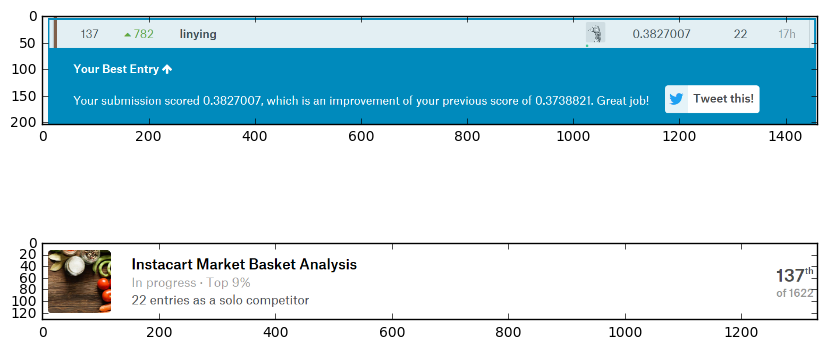

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, (ax1,ax2)=plt.subplots(nrows=2, ncols=1,figsize=(10,5))

ax1.imshow(plt.imread("fig1.png"))
ax2.imshow(plt.imread("fig2.png"))